snow and temperature

check for TObs and snwd

1st eigen vector and 0th eigen vector coeff of tobs with 1st eigen vector of snwd

In [43]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py','lib/Eigen_decomp.py','lib/recon_plot.py'])#,'lib/spark_PCA.py'

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)


### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSBSSBB'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()



Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


In [44]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
#from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions
from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets


    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.11.3 	required version>=1.12.0 ******* Update Version ******
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=5.2.2 	required version>=6.0.0 ******* Update Version ******


In [66]:
import pickle
List=pickle.load(open(data_dir+'/US_Weather_SSSBSSBB.csv','rb'))
len(List)

df=sqlContext.createDataFrame(List)
print df.count()

df.show(10)

12423
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1219.2|   37.75|  -117.65|       TMAX|USC00267465|    43|[30 55 40 56 80 5...|1898.0|SSSBSSBB|
|    640.1|  37.495|-119.9858|       TMAX|USC00045352|     3|[00 58 50 57 E0 5...|2007.0|SSSBSSBB|
|   1219.2|   37.75|  -117.65|       TMIN|USC00267465|    45|[90 D5 E0 D5 40 D...|1898.0|SSSBSSBB|
|    640.1|  37.495|-119.9858|       TMIN|USC00045352|    24|[00 46 00 46 E0 5...|2007.0|SSSBSSBB|
|   1452.4| 37.9747|-119.9161|       TMAX|USC00041697|     0|[80 54 00 53 80 5...|1956.0|SSSBSSBB|
|   1452.4| 37.9747|-119.9161|       TMAX|USC00041697|    10|[B0 58 A0 56 A0 5...|1957.0|SSSBSSBB|
|   1452.4| 37.9747|-119.9161|       TMAX|USC00041697|     0|[80 58 80 58 90 5...|1958.0|SSSBSSBB|
|   

In [67]:
#comparing snow and elevation

#seeing stations with max observations

In [68]:
#not needed
sqlContext.registerDataFrameAsTable(df,'weather')
meas='SNWD'
q = "SELECT station, COUNT(station) as count0 FROM weather WHERE measurement = '%s' GROUP BY station ORDER BY count0 DESC"%(meas)
df_temp = sqlContext.sql(q)
df_temp.show(5)

+-----------+------+
|    station|count0|
+-----------+------+
|USC00043939|    80|
|USC00048353|    63|
|USC00045532|    60|
|USC00049073|    60|
|USC00043261|    59|
+-----------+------+
only showing top 5 rows



In [70]:
#sqlContext.registerDataFrameAsTable(df,'weather')#included above
meas='SNWD'
Query="SELECT * FROM weather\n\tWHERE measurement='%s'"%(meas)
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(100)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='SNWD'
1658 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    640.1|  37.495|-119.9858|       SNWD|USC00045352|     0|[00 00 00 00 00 0...|1985.0|SSSBSSBB|
|    640.1|  37.495|-119.9858|       SNWD|USC00045352|    31|[00 00 00 00 00 0...|1986.0|SSSBSSBB|
|    640.1|  37.495|-119.9858|       SNWD|USC00045352|    35|[00 00 00 00 00 0...|1988.0|SSSBSSBB|
|    640.1|  37.495|-119.9858|       SNWD|USC00045352|    30|[00 00 00 00 00 0...|1990.0|SSSBSSBB|
|    640.1|  37.495|-119.9858|       SNWD|USC00045352|    31|[00 00 00 00 00 0...|1991.0|SSSBSSBB|
|    640.1|  37.495|-119.9858|       SNWD|USC00045352|    32|[00 7E 00 7E 00 7...|1996.0|SSSBSSBB|
|    640.1|  37.495|-119.9858|       SNWD|USC000453

(1658L, 365L)

In [71]:
sqlContext.registerDataFrameAsTable(df1,'snwdtable')
Query="SELECT * FROM snwdtable WHERE elevation>1000"
print Query
df2=sqlContext.sql(Query)
print df2.count(),'rows'
df2.show(10)

SELECT * FROM snwdtable WHERE elevation>500
1223 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    640.1|  37.495|-119.9858|       SNWD|USC00045352|     0|[00 00 00 00 00 0...|1985.0|SSSBSSBB|
|    640.1|  37.495|-119.9858|       SNWD|USC00045352|    31|[00 00 00 00 00 0...|1986.0|SSSBSSBB|
|    640.1|  37.495|-119.9858|       SNWD|USC00045352|    35|[00 00 00 00 00 0...|1988.0|SSSBSSBB|
|    640.1|  37.495|-119.9858|       SNWD|USC00045352|    30|[00 00 00 00 00 0...|1990.0|SSSBSSBB|
|    640.1|  37.495|-119.9858|       SNWD|USC00045352|    31|[00 00 00 00 00 0...|1991.0|SSSBSSBB|
|    640.1|  37.495|-119.9858|       SNWD|USC00045352|    32|[00 7E 00 7E 00 7...|1996.0|SSSBSSBB|
|    640.1|  37.495|-119.9858|       SNWD|USC00045352| 

In [73]:
sqlContext.registerDataFrameAsTable(df1,'snwdtable')
Query="SELECT * FROM snwdtable WHERE elevation<=1000"
print Query
df3=sqlContext.sql(Query)
print df3.count(),'rows'

SELECT * FROM snwdtable WHERE elevation<500
435 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    103.9|    37.8|  -120.65|       SNWD|USC00044590|     0|[00 00 00 00 00 0...|1960.0|SSSBSSBB|
|    103.9|    37.8|  -120.65|       SNWD|USC00044590|     1|[00 00 00 00 00 0...|1961.0|SSSBSSBB|
|    103.9|    37.8|  -120.65|       SNWD|USC00044590|     0|[00 00 00 00 00 0...|1962.0|SSSBSSBB|
|    103.9|    37.8|  -120.65|       SNWD|USC00044590|     0|[00 00 00 00 00 0...|1963.0|SSSBSSBB|
|    103.9|    37.8|  -120.65|       SNWD|USC00044590|     0|[00 00 00 00 00 0...|1964.0|SSSBSSBB|
|    103.9|    37.8|  -120.65|       SNWD|USC00044590|     0|[00 00 00 00 00 0...|1965.0|SSSBSSBB|
|    103.9|    37.8|  -120.65|       SNWD|USC00044590|  

In [ ]:
df3.show(200)

In [74]:
rows=df3.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)

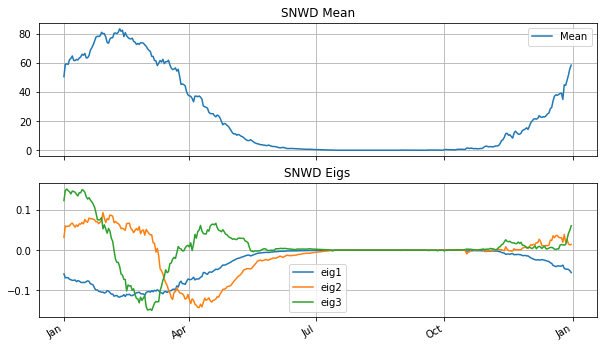

In [77]:
Mean=STAT[meas]['Mean']
k=3
EigVec=np.matrix(STAT[meas]['eigvec'][:,:k])
v=[np.array(EigVec[:,i]).flatten() for i in range(np.shape(EigVec)[1])]



import pylab as plt
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=meas+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=meas+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

In [78]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)


In [79]:
rdd2=df2.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)

In [80]:

row,=df2.take(1)
df2.show(100)
#filter out vectors for which the mean is a worse approximation than zero.
#print 'before filter',df2.count()
#df3=df2.filter(df2.res_mean<1)
#print 'after filter',df3.count()

+-------------------+-------------------+-------------------+---------+--------+--------+---------+-----------+--------------------+--------------------+--------------------+------------------+-----------+------------+------+--------------------+------+
|            coeff_1|            coeff_2|            coeff_3|elevation|   label|latitude|longitude|measurement|               res_1|               res_2|               res_3|          res_mean|    station|   total_var|undefs|              vector|  year|
+-------------------+-------------------+-------------------+---------+--------+--------+---------+-----------+--------------------+--------------------+--------------------+------------------+-----------+------------+------+--------------------+------+
|  681.6358278435839| -93.27347387310544| -45.39083497467258|    640.1|SSSBSSBB|  37.495|-119.9858|       SNWD| 0.02822233907207044|0.010026235672191993|0.005717017964935...|          Infinity|USC00045352|         0.0|     0|[00 00 00 00 

In [81]:
rdd3=df3.rdd.map(decompose)
df3=sqlContext.createDataFrame(rdd3)

In [82]:
sqlContext.registerDataFrameAsTable(df2,'highelevation')
Query="SELECT elevation,coeff_1,coeff_2,coeff_3 FROM highelevation"
df2=sqlContext.sql(Query)
print df2.count(),'rows'


1223 rows


In [83]:
df2.show(100)

+---------+-------------------+-------------------+-------------------+
|elevation|            coeff_1|            coeff_2|            coeff_3|
+---------+-------------------+-------------------+-------------------+
|    640.1|  681.6358278435839| -93.27347387310544| -45.39083497467258|
|    640.1|  681.6358278435839| -93.27347387310544| -45.39083497467258|
|    640.1|  681.6358278435839| -93.27347387310544| -45.39083497467258|
|    640.1|  681.6358278435839| -93.27347387310544| -45.39083497467258|
|    640.1|  681.6358278435839| -93.27347387310544| -45.39083497467258|
|    640.1|  681.6358278435839| -93.27347387310544| -45.39083497467258|
|    640.1|  681.6358278435839| -93.27347387310544| -45.39083497467258|
|    640.1|  681.6358278435839| -93.27347387310544| -45.39083497467258|
|    640.1|  681.6358278435839| -93.27347387310544| -45.39083497467258|
|    640.1|  681.6358278435839| -93.27347387310544| -45.39083497467258|
|    640.1|  681.6358278435839| -93.27347387310544| -45.39083497

In [84]:
sqlContext.registerDataFrameAsTable(df3,'lowelevation')
Query="SELECT elevation,coeff_1,coeff_2,coeff_3 FROM lowelevation"
df3=sqlContext.sql(Query)
print df3.count(),'rows'

435 rows


In [85]:
df3.show(400)

+---------+-----------------+------------------+-------------------+
|elevation|          coeff_1|           coeff_2|            coeff_3|
+---------+-----------------+------------------+-------------------+
|    103.9|681.6358278435839|-93.27347387310544| -45.39083497467258|
|    103.9|681.6358278435839|-93.27347387310544| -45.39083497467258|
|    103.9|677.3103013825322|-89.28172557151791| -39.27191688736596|
|    103.9|681.6358278435839|-93.27347387310544| -45.39083497467258|
|    103.9|681.6358278435839|-93.27347387310544| -45.39083497467258|
|    103.9|681.6358278435839|-93.27347387310544| -45.39083497467258|
|    103.9|681.6358278435839|-93.27347387310544| -45.39083497467258|
|    103.9|681.6358278435839|-93.27347387310544| -45.39083497467258|
|    103.9|681.6358278435839|-93.27347387310544| -45.39083497467258|
|    103.9|681.6358278435839|-93.27347387310544| -45.39083497467258|
|    103.9|681.6358278435839|-93.27347387310544| -45.39083497467258|
|    103.9|681.6358278435839|-93.2

interpreting tobs and snow?

In [ ]:
df5=df3.filter(df3.elevation<103).sort(df3.coeff_1,ascending=False)
rows=df5.take(12)
#df5.select('coeff_2','res_2').show(4)
df5.select('coeff_1','elevation','res_1').show(4)